In [1]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
weatherPred = pd.read_csv("../../data/forecast_weather.csv")
weatherHist = pd.read_csv("../../data/historical_weather.csv")

In [4]:
weatherHist.fillna(0,inplace=True)
weatherPred.fillna(0,inplace=True)

In [5]:
weatherPred['datetime'] = pd.to_datetime(weatherPred['forecast_datetime']).dt.tz_convert(None)
weatherHist['datetime'] = pd.to_datetime(weatherHist['datetime'])
#weatherPred.loc[(weatherPred.data_block_id == 3) & (weatherPred.latitude == 57.6) & (weatherPred.longitude == 21.7)]
#weatherHist.loc[(weatherHist.data_block_id == 3) & (weatherHist.latitude == 57.6) & (weatherHist.longitude == 21.7)]

In [6]:
train = pd.merge(weatherPred, weatherHist, on=['data_block_id','latitude','longitude','datetime'], how='inner',suffixes=('_pred', '_hist'))
# only from hours ahead 1-10 (only 10 hours overlap)
# 2 weatherstations are not included for historic data

In [7]:
target = pd.merge(weatherPred.loc[(weatherPred.hours_ahead > 23) & (weatherPred.hours_ahead < 48)], weatherHist, on=['latitude','longitude','datetime'], how='inner',suffixes=('_pred', '_hist'))

# create target df

In [8]:
# pairs missing in hist! -> far away outside of estonia / can drop!
unique_pairs_t = list(set(zip(target['latitude'], target[ 'longitude'])))
unique_pairs_train = list(set(zip(train['latitude'], train[ 'longitude'])))
unique_pairs = list(set(zip(weatherPred['latitude'], weatherPred[ 'longitude'])))
for pair in unique_pairs:
    if not pair in unique_pairs_t:
        print(pair)
    if not pair in unique_pairs_train:
        print(pair)

(57.6, 24.2)
(57.6, 24.2)
(57.6, 23.2)
(57.6, 23.2)


In [9]:
target = target.drop_duplicates()
target = target.loc[(target.hours_ahead > 23) & (target.hours_ahead < 48)]
# features with the same hist and pred value:
#    temperature, dewpoint, direct_solar_radiation
# features possible to use / to be converted
#    total cloud cover (cloud cover hist in percentage -> pred value = hist value / 100)
#    surface solar radiation (pred) = direct + diffuse + short wave solar radiation (hist) -> approximation!!!
#    snow in in meter water equivalent / volume=h_w*A (pred) vs. snow height in cm /volume = h*A
#       snow density 150kg/m^3, water density = 1000 kg/m^3
#       mass water = const = snow density * snow volume = water dens * h_w*A = snow_dens * h_s / 100 * A
#       h_s = water_dens/snow_dens * 100 * h_w ... predicted snow height in cm
#    wind u = windspeed * cos(phi), v = windspeed*sin(phi)

# not used, wind, pressure, rain

In [10]:
targetD = target[['latitude', 'longitude','datetime', 'hours_ahead',
       'temperature_pred','temperature_hist',
       'dewpoint_pred', 'dewpoint_hist',
       'cloudcover_total_pred','cloudcover_total_hist',
       'direct_solar_radiation_pred', 'direct_solar_radiation_hist',
       'surface_solar_radiation_downwards',
       'snowfall_hist','10_metre_u_wind_component','10_metre_v_wind_component','windspeed_10m','shortwave_radiation','diffuse_radiation',#'surface_solar_radiation_downwards',
       'data_block_id_pred']]

targetD['Date'] = targetD['datetime'].dt.date

targetD['cloudcover_total_hist'] = targetD['cloudcover_total_hist'] / 100
targetD['surface_solar_radiation_downwards_hist'] = target['diffuse_radiation'] + targetD['direct_solar_radiation_hist'] #target['shortwave_radiation']#
targetD['snowfall_pred'] = 1000/200 * 100 * target['snowfall_pred']
targetD['10_metre_u_wind_component_hist'] = np.cos(target['winddirection_10m']) * target['windspeed_10m']
targetD['10_metre_v_wind_component_hist'] = np.sin(target['winddirection_10m']) * target['windspeed_10m']
targetD['windspeed_10m_pred'] = np.sqrt(targetD['10_metre_u_wind_component']*targetD['10_metre_u_wind_component'] + targetD['10_metre_v_wind_component']*targetD['10_metre_v_wind_component'])

targetD['diff_temperature']                       = abs(targetD['temperature_pred'] - targetD['temperature_hist'])#/targetD['temperature_hist'] #no normalization, otherwise numerical problems when temp close to 0
targetD['diff_dewpoint']                          = abs(targetD['dewpoint_pred'] - targetD['dewpoint_hist'])#/targetD['dewpoint_hist']
targetD['diff_cloudcover_total']                  = abs(targetD['cloudcover_total_pred'] - targetD['cloudcover_total_hist']) # Cloudcover is already in %!!

max_dirRad_per_day = targetD.groupby('Date')['direct_solar_radiation_hist'].transform('max')
targetD['diff_direct_solar_radiation']            = abs(targetD['direct_solar_radiation_pred'] - targetD['direct_solar_radiation_hist'])#/max_dirRad_per_day

# normalize over the maximum day value to get rid of seasonal effects
max_solRad_per_day = targetD.groupby('Date')['surface_solar_radiation_downwards_hist'].transform('max')
targetD['diff_surface_solar_radiation_downwards'] = abs(targetD['surface_solar_radiation_downwards'] - targetD['surface_solar_radiation_downwards_hist'])#/max_solRad_per_day
targetD['diff_snowfall']                          = abs(targetD['snowfall_pred'] - targetD['snowfall_hist'])#/targetD['snowfall_hist']
targetD['diff_10_metre_u_wind_component']         = abs(targetD['10_metre_u_wind_component'] - targetD['10_metre_u_wind_component_hist'])#/(abs(targetD['10_metre_u_wind_component_hist']))
targetD['diff_10_metre_v_wind_component']         = abs(targetD['10_metre_u_wind_component'] - targetD['10_metre_v_wind_component_hist'])#/abs(targetD['10_metre_v_wind_component_hist'])
targetD['diff_windspeed_10m']                     = abs(targetD['windspeed_10m_pred'] - targetD['windspeed_10m'])#/targetD['windspeed_10m']


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_13749/1814869933.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_13749/1814869933.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_13749/1814869933.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [27]:
absError_temp = 0
absError_dewp = 0
absError_cloudcover = 0
absError_directSolRad = 0
absError_snowfall = 0
absError_windV = 0
absError_windU = 0
absError_surfSolRad = 0

for pair in unique_pairs:
    sub = targetD.loc[(targetD.latitude == pair[0]) & (targetD.longitude == pair[1])]
    error_temp = sub['diff_temperature'].sum()
    error_dewp = sub['diff_dewpoint'].sum()
    error_cloudcover = sub['diff_cloudcover_total'].sum()
    error_directSolRad = sub['diff_direct_solar_radiation'].sum()
    error_snowfall = sub['diff_snowfall'].sum()
    error_windV = sub['diff_10_metre_v_wind_component'].sum()
    error_windU = sub['diff_10_metre_u_wind_component'].sum()
    error_surfSolRad = sub['diff_surface_solar_radiation_downwards'].sum()
    #print(error_temp,error_dewp,error_cloudcover,error_directSolRad,error_snowfall,error_windV,error_windU,error_surfSolRad)
    
    absError_temp = absError_temp + error_temp
    absError_dewp = absError_dewp +error_dewp
    absError_cloudcover = absError_cloudcover +error_cloudcover
    absError_directSolRad = absError_directSolRad +error_directSolRad
    absError_snowfall = absError_snowfall +error_snowfall
    absError_windV = absError_windV +error_windV
    absError_windU = absError_windU+error_windU
    absError_surfSolRad = absError_surfSolRad+error_surfSolRad
    #print(sub.shape)
dim = targetD.shape[0]
print(absError_temp,absError_dewp,absError_cloudcover,absError_directSolRad,absError_snowfall,absError_windV,absError_windU,absError_surfSolRad)
print(absError_temp/dim,absError_dewp/dim,absError_cloudcover/dim,absError_directSolRad/dim,absError_snowfall/dim,absError_windV/dim,absError_windU/dim,absError_surfSolRad/dim)

2481023.4290893567 1947292.996423346 369327.705232332 186292019.5364565 27303.300229631583 7008452.585983683 6989886.695282099 139810426.64375
1.4789035765698564 1.160754285217271 0.22015111094493475 111.04608313997682 0.016275117714863157 4.177641159735387 4.166574290378633 83.339051772313


In [46]:

for i,pair in enumerate(unique_pairs):
    if i<50:
        continue
    sub = targetD.loc[(targetD.latitude == pair[0]) & (targetD.longitude == pair[1])]
    fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)
    fig.update_layout(title_text=str(pair[0])+' '+str(pair[1]), title_x=0.5)
    #fig.update_layout(width=1000, height=1500)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['temperature_pred'],mode ='markers', name='temperature_pred'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['temperature_hist'],mode ='markers', name='temperature_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_temperature'],mode ='markers', name='diff_temperature'),row=1, col=1)
    #print(sub['diff_temperature'].mean(),sub['diff_temperature'].std())

    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['dewpoint_pred'],mode ='markers', name='dewpoint_pred'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['dewpoint_hist'],mode ='markers', name='dewpoint_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_dewpoint'],mode ='markers', name='diff_dewpoint'),row=1, col=1)
    #print(sub['diff_dewpoint'].mean(),sub['diff_dewpoint'].std())

    # hist value = 0.01 accuracy, pred = continuous!!
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['cloudcover_total_pred'],mode ='markers', name='cloudcover_total_pred'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['cloudcover_total_hist'],mode ='markers', name='cloudcover_total_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_cloudcover_total'],mode ='markers', name='diff_cloudcover_total'),row=1, col=1)
    #print(sub['diff_cloudcover_total'].mean(),sub['diff_cloudcover_total'].std())

    # hist value is discrete in steps of 1, pred = continuous!, very noisy
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['direct_solar_radiation_pred'],mode ='markers', name='direct_solar_radiation_pred'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['direct_solar_radiation_hist'],mode ='markers', name='direct_solar_radiation_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_direct_solar_radiation'],mode ='markers', name='diff_direct_solar_radiation'),row=1, col=1)
    #print(sub['diff_direct_solar_radiation'].mean(),sub['diff_direct_solar_radiation'].std())

    ## downward solar radiation = diffuse + direct solar radiation 
    #sub = sub.dropna()
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['surface_solar_radiation_downwards'],mode ='markers', name='surface_solar_radiation_downwards'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['surface_solar_radiation_downwards_hist'],mode ='markers', name='surface_solar_radiation_downwards_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_surface_solar_radiation_downwards'],mode ='markers', name='diff_surface_solar_radiation_downwards'),row=1, col=1)
    #print(sub['diff_surface_solar_radiation_downwards'].mean(),sub['diff_surface_solar_radiation_downwards'].std())

    fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['snowfall_pred'],mode ='markers', name='snowfall_pred'),row=1, col=1)
    fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['snowfall_hist'],mode ='markers', name='snowfall_hist'),row=1, col=1)
    fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_snowfall'],mode ='markers', name='diff_snowfall'),row=1, col=1)
    print(sub['diff_snowfall'].mean(),sub['diff_snowfall'].std())

    ## abs velocity is not really better, very similar, can't use relative error for this term
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['10_metre_v_wind_component'],mode ='markers', name='10_metre_v_wind_component'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['10_metre_v_wind_component_hist'],mode ='markers', name='10_metre_v_wind_component_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_10_metre_v_wind_component'],mode ='markers', name='diff_10_metre_v_wind_component'),row=1, col=1)
    #print(sub['diff_10_metre_v_wind_component'].mean(),sub['diff_10_metre_v_wind_component'].std())

    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['10_metre_u_wind_component'],mode ='markers', name='10_metre_u_wind_component'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['10_metre_u_wind_component_hist'],mode ='markers', name='10_metre_u_wind_component_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_10_metre_u_wind_component'],mode ='markers', name='diff_10_metre_u_wind_component'),row=1, col=1)
    #print(sub['diff_10_metre_u_wind_component'].mean(),sub['diff_10_metre_u_wind_component'].std())

    # a bit more stable when calculating relative error, because no division / 0
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['windspeed_10m_pred'],mode ='markers', name='windspeed_10m_pred'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['windspeed_10m'],mode ='markers', name='snowfall_hist'),row=1, col=1)
    #fig.add_trace(go.Scatter(x = sub['datetime'], y = sub['diff_windspeed_10m'],mode ='markers', name='diff_windspeed_10m'),row=1, col=1)
    #print(sub['diff_windspeed_10m'].mean(),sub['diff_windspeed_10m'].std())
    fig.show()
    break


0.01682294808678502 0.07673201358467388


# create train df 

In [11]:
trainCov = train[['latitude', 'longitude',
       'temperature_pred', 'dewpoint_pred', 'cloudcover_total_pred',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'data_block_id', 'direct_solar_radiation_pred',
       'surface_solar_radiation_downwards', 'snowfall_pred',
       #'total_precipitation', 'rain', # rain = gt, let's not consider for now
       
       'datetime', 'temperature_hist', 'dewpoint_hist',
       'snowfall_hist', 'cloudcover_total_hist',
       'direct_solar_radiation_hist']]

trainCov['Date'] = trainCov['datetime'].dt.date

trainCov['cloudcover_total_hist'] = trainCov['cloudcover_total_hist'] / 100
trainCov['surface_solar_radiation_downwards_hist'] = train['diffuse_radiation'] + trainCov['direct_solar_radiation_hist']
trainCov['snowfall_pred'] = 1000/200 * 100 * train['snowfall_pred']
trainCov['10_metre_u_wind_component_hist'] = np.cos(train['winddirection_10m']) * train['windspeed_10m']
trainCov['10_metre_v_wind_component_hist'] = np.sin(train['winddirection_10m']) * train['windspeed_10m']

trainCov['diff_temperature']                       = abs(trainCov['temperature_pred'] - trainCov['temperature_hist'])
trainCov['diff_dewpoint']                          = abs(trainCov['dewpoint_pred'] - trainCov['dewpoint_hist'])
trainCov['diff_cloudcover_total']                  = abs(trainCov['cloudcover_total_pred'] - trainCov['cloudcover_total_hist'])

max_dirRad_per_day = trainCov.groupby('Date')['direct_solar_radiation_hist'].transform('max')
trainCov['diff_direct_solar_radiation']            = abs(trainCov['direct_solar_radiation_pred'] - trainCov['direct_solar_radiation_hist'])#/max_dirRad_per_day

# normalize over the maximum day value to get rid of seasonal effects
max_solRad_per_day = trainCov.groupby('Date')['surface_solar_radiation_downwards_hist'].transform('max')
trainCov['diff_surface_solar_radiation_downwards'] = abs(trainCov['surface_solar_radiation_downwards'] - trainCov['surface_solar_radiation_downwards_hist'])#/max_solRad_per_day
trainCov['diff_snowfall']                          = abs(trainCov['snowfall_pred'] - trainCov['snowfall_hist'])
trainCov['diff_10_metre_u_wind_component']         = abs(trainCov['10_metre_u_wind_component'] - trainCov['10_metre_u_wind_component_hist'])
trainCov['diff_10_metre_v_wind_component']         = abs(trainCov['10_metre_u_wind_component'] - trainCov['10_metre_v_wind_component_hist'])

trainCov = trainCov.drop_duplicates()

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_13749/1499101546.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_13749/1499101546.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_13749/1499101546.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

# investigate correlations

In [47]:
feat = ['diff_temperature','diff_dewpoint','diff_cloudcover_total','diff_direct_solar_radiation',
    'diff_surface_solar_radiation_downwards','diff_snowfall','diff_10_metre_u_wind_component','diff_10_metre_v_wind_component',
    'diff_windspeed_10m']
corr_matrix = targetD[feat].corr()

<AxesSubplot:>

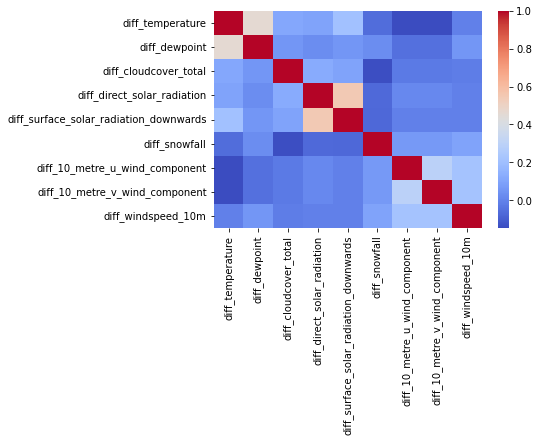

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap="coolwarm")

seems I can just use the combined error!

# create a trainable dataframe

In [12]:
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
targetD['weatherStationId'] = list(map(pair_index_dict.get, zip(targetD['latitude'], targetD['longitude'])))
trainD = trainCov
trainD['weatherStationId'] = list(map(pair_index_dict.get, zip(trainCov['latitude'], trainCov['longitude'])))

feat = ['diff_temperature','diff_dewpoint','diff_cloudcover_total','diff_direct_solar_radiation',
    'diff_surface_solar_radiation_downwards','diff_snowfall',
    'diff_windspeed_10m','latitude', 'longitude','datetime','data_block_id_pred']
targ = targetD.groupby(['weatherStationId','Date'])[feat].mean()


In [14]:
trainCov['hour']    = trainCov['datetime'].dt.hour.astype(int)
trainCov['yearday'] = trainCov['datetime'].dt.day_of_year.astype(int)
trainCov['weekday'] = trainCov['datetime'].dt.day_of_week.astype(int)
trainCov['month']   = trainCov['datetime'].dt.month.astype(int)
targ = targ.reset_index()

In [15]:
trainCov = trainCov.loc[trainCov.data_block_id < 637]
targetCov = targ.loc[targ.weatherStationId.isna() == False]

trainCov = trainCov.sort_values(by=['Date','weatherStationId','hour'])
targetCov = targetCov.sort_values(by=['Date','weatherStationId'])


In [16]:
targetCov.to_csv('gtWeatherCorrelationScore.csv')

In [17]:
trainDays  = len(trainCov.data_block_id.unique())
targetDays = len(targetCov.data_block_id_pred.unique())

trainStat  = len(trainCov.weatherStationId.unique())
targetStat = len(targetCov.weatherStationId.unique())

trainHour = len(trainCov.hour.unique())
print(trainDays,targetDays,trainStat,targetStat,trainHour)
print(trainCov.shape,targetCov.shape)

636 636 110 110 10
(699600, 34) (69960, 14)


In [18]:
#add some more time features and order / drop not important ones
orderedTrainFeat = [#'latitude', 'longitude', 'data_block_id','datetime','Date',
#drop them if we can add good time features
        'temperature_pred', 'dewpoint_pred',
       'cloudcover_total_pred', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 
       'direct_solar_radiation_pred', 'surface_solar_radiation_downwards',
       'snowfall_pred',  'temperature_hist', 'dewpoint_hist',
       'snowfall_hist', 'cloudcover_total_hist', 'direct_solar_radiation_hist',
        'surface_solar_radiation_downwards_hist',
       '10_metre_u_wind_component_hist', '10_metre_v_wind_component_hist',
# kepp them
       'diff_temperature', 'diff_dewpoint', 'diff_cloudcover_total',
       'diff_direct_solar_radiation', 'diff_surface_solar_radiation_downwards',
       'diff_snowfall', 'diff_10_metre_u_wind_component',
       'diff_10_metre_v_wind_component', 'weatherStationId',  'hour', 'yearday',
       'weekday', 'month']

predictedFeatures = ['diff_temperature',
       'diff_dewpoint', 'diff_cloudcover_total', 'diff_direct_solar_radiation',
       'diff_surface_solar_radiation_downwards', 'diff_snowfall',
       'diff_windspeed_10m']
#trainCov.columns
#trainCov = trainCov[orderedTrainFeat]

In [20]:
reshaped_train = trainCov[orderedTrainFeat].values.reshape((trainDays, trainStat, trainHour, -1))
reshaped_target = targetCov[predictedFeatures].values.reshape((targetDays, targetStat, -1))

print(reshaped_target.shape, reshaped_train.shape)

(636, 110, 7) (636, 110, 10, 29)


In [1]:
#reshaped_target[:,:,2:9] #2:9 are important features
#reshaped_train

# try out different NN 

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.random.set_seed(42)

2023-12-10 13:08:29.395750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## use one transformer net on the data for all weather stations

In [39]:
# Assuming num_features is the number of features at each subcategory
num_features = 29
num_subcategories = 10
num_weatherStations = 110
num_output_values = 7

# Input layer
input_layer = layers.Input(shape=(num_subcategories, num_features))

# Positional encoding to provide positional information to the model
positional_encoding = layers.Embedding(input_dim=num_subcategories, output_dim=num_features)(tf.range(0, num_subcategories))
#positional_encoding = layers.Reshape((num_features))(positional_encoding)

# Add positional encoding to the input
encoded_input = layers.Add()([input_layer, positional_encoding])

# Transformer blocks
num_heads = 2
for _ in range(2):  # You can adjust the number of transformer blocks
    transformer_block = layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_features)(encoded_input, encoded_input)
    transformer_block = layers.Dropout(0.1)(transformer_block)
    transformer_block = layers.LayerNormalization(epsilon=1e-6)(encoded_input + transformer_block)

# Global Average Pooling to aggregate information across subcategories
pooled_output = layers.GlobalAveragePooling1D()(transformer_block)

# Dense layers
dense_layer = layers.Dense(64, activation='relu')(pooled_output)

# Output layer
output_layer = layers.Dense(num_output_values)(dense_layer)

# Model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 10, 29)]     0           []                               
                                                                                                  
 add (Add)                      (10, 10, 29)         0           ['input_6[0][0]']                
                                                                                                  
 multi_head_attention_5 (MultiH  (10, 10, 29)        6931        ['add[0][0]',                    
 eadAttention)                                                    'add[0][0]']                    
                                                                                                  
 dropout_5 (Dropout)            (10, 10, 29)         0           ['multi_head_attention_5[0]

In [31]:
# training it
numDaysTrain1 = int(0.5*trainDays) #use 50% of training days
numDaysTest1 = trainDays-numDaysTrain1

X_train1 = reshaped_train[0:numDaysTrain1,:,:,:].reshape(-1,10,29)
X_val1 = reshaped_train[numDaysTrain1:trainDays,:,:,:].reshape(-1,10,29)
y_train1 = reshaped_target[0:numDaysTrain1,:,:].reshape(-1,7)
y_val1 = reshaped_target[numDaysTrain1:trainDays,:,:].reshape(-1,7)
print(X_train1.shape, X_val1.shape, y_train1.shape, y_val1.shape)

(34980, 10, 29) (34980, 10, 29) (34980, 7) (34980, 7)


In [41]:
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=5, batch_size=1) #batch size = 110 weather station

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

Epoch 1/5
34980/34980 [==============================] - 76s 2ms/step - loss: 766.4330 - val_loss: 852.9091
Epoch 2/5
34980/34980 [==============================] - 74s 2ms/step - loss: 692.3718 - val_loss: 728.8974
Epoch 3/5
34980/34980 [==============================] - 75s 2ms/step - loss: 666.8522 - val_loss: 764.6811
Epoch 4/5
34980/34980 [==============================] - 76s 2ms/step - loss: 659.6163 - val_loss: 711.3792
Epoch 5/5
34980/34980 [==============================] - 77s 2ms/step - loss: 640.9751 - val_loss: 845.3866


## using multi head transformer

In [45]:
# Assuming num_features is the number of features at each time step
# and num_stations is the number of weather stations
num_features = 29
num_time_steps = 10
num_stations = 110
num_output_values = 7

# Input layer
input_layer = layers.Input(shape=(num_stations, num_time_steps, num_features))

# Add positional encoding to the input
encoded_input = input_layer#layers.Add()([input_layer, positional_encoding])

# Transformer blocks with individual attention heads for each weather station
num_heads = 4
transformer_blocks = []
for station in range(num_stations):
    transformer_block = layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_features)(encoded_input[:, station, :, :], encoded_input[:, station, :, :])
    transformer_block = layers.Dropout(0.1)(transformer_block)
    transformer_block = layers.LayerNormalization(epsilon=1e-6)(encoded_input[:, station, :, :] + transformer_block)
    transformer_blocks.append(transformer_block)

# Concatenate transformer blocks for all weather stations
transformer_output = layers.Concatenate(axis=-1)(transformer_blocks)

# Global Average Pooling to reduce the sequence length
pooled_output = layers.GlobalAveragePooling1D()(transformer_output)

# Dense layers
dense_layer = layers.Dense(128, activation='relu')(pooled_output)

# Output layer with individual heads for each weather station
output_heads = []
for station in range(num_stations):
    output_head = layers.Dense(num_output_values)(dense_layer)
    output_heads.append(output_head)

# Concatenate output heads
output_layer = layers.Concatenate(axis=-1)(output_heads)

# Reshape output for each day
output_layer = layers.Reshape((num_stations, num_output_values))(output_layer)

# Model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
#model.summary()


In [46]:
# training it
numDaysTrain2 = int(0.5*trainDays) #use 50% of training days
numDaysTest2 = trainDays-numDaysTrain2

X_train2 = reshaped_train[0:numDaysTrain1,:,:,:]
X_val2 = reshaped_train[numDaysTrain1:trainDays,:,:,:]
y_train2 = reshaped_target[0:numDaysTrain1,:,:]
y_val2 = reshaped_target[numDaysTrain1:trainDays,:,:]
print(X_train2.shape, X_val2.shape, y_train2.shape, y_val2.shape)

(318, 110, 10, 29) (318, 110, 10, 29) (318, 110, 7) (318, 110, 7)


In [50]:
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=50, batch_size=20) #batch size = 110 weather station

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

Epoch 1/50
16/16 [==============================] - 47s 445ms/step - loss: 424.7087 - val_loss: 699.5007
Epoch 2/50
16/16 [==============================] - 2s 94ms/step - loss: 408.1035 - val_loss: 742.5508
Epoch 3/50
16/16 [==============================] - 1s 92ms/step - loss: 391.7830 - val_loss: 704.8464
Epoch 4/50
16/16 [==============================] - 1s 92ms/step - loss: 374.9558 - val_loss: 759.4941
Epoch 5/50
16/16 [==============================] - 1s 93ms/step - loss: 386.8448 - val_loss: 735.5963
Epoch 6/50
16/16 [==============================] - 1s 93ms/step - loss: 366.5574 - val_loss: 731.3125
Epoch 7/50
16/16 [==============================] - 1s 92ms/step - loss: 363.8817 - val_loss: 802.5278
Epoch 8/50
16/16 [==============================] - 2s 96ms/step - loss: 365.0892 - val_loss: 735.9613
Epoch 9/50
16/16 [==============================] - 2s 96ms/step - loss: 349.7846 - val_loss: 814.8624
Epoch 10/50
16/16 [==============================] - 2s 97ms/step - los

# try normal network

In [52]:
# Assuming num_features is the number of features at each time step
# and num_stations is the number of weather stations
num_features = 29
num_time_steps = 10
num_stations = 110
num_output_values = 7

# Input layer
input_layer = layers.Input(shape=(num_stations, num_time_steps, num_features))

# Add positional encoding to the input
encoded_input = input_layer#layers.Add()([input_layer, positional_encoding])

# Transformer blocks with individual attention heads for each weather station
num_heads = 4
transformer_blocks = []
for station in range(num_stations):
    dense_layer = layers.Dense(128, activation='relu')(encoded_input[:, station, :, :])
    dense_layer = layers.Dropout(0.1)(dense_layer)
    dense_layer = layers.LayerNormalization(epsilon=1e-6)(dense_layer)
    transformer_blocks.append(dense_layer)

# Concatenate transformer blocks for all weather stations
transformer_output = layers.Concatenate(axis=-1)(transformer_blocks)

# Global Average Pooling to reduce the sequence length
pooled_output = layers.GlobalAveragePooling1D()(transformer_output)

# Dense layers
dense_layer = layers.Dense(128, activation='relu')(pooled_output)
dense_layer = layers.Dense(128, activation='relu')(dense_layer)

# Output layer with individual heads for each weather station
output_heads = []
for station in range(num_stations):
    output_head = layers.Dense(num_output_values)(dense_layer)
    output_heads.append(output_head)

# Concatenate output heads
output_layer = layers.Concatenate(axis=-1)(output_heads)

# Reshape output for each day
output_layer = layers.Reshape((num_stations, num_output_values))(output_layer)

# Model
model3 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
#model.summary()


In [53]:
#model = keras.Model(inputs=input_layer, outputs=output_layer)
#model.compile(optimizer='adam', loss='mean_squared_error')
history = model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=50, batch_size=20) #batch size = 110 weather station

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

Epoch 1/50
16/16 [==============================] - 32s 344ms/step - loss: 4469.6147 - val_loss: 3587.2700
Epoch 2/50
16/16 [==============================] - 1s 59ms/step - loss: 3163.3342 - val_loss: 2047.6163
Epoch 3/50
16/16 [==============================] - 1s 53ms/step - loss: 1655.4153 - val_loss: 1049.7504
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 977.5110 - val_loss: 798.2094
Epoch 5/50
16/16 [==============================] - 1s 54ms/step - loss: 806.1619 - val_loss: 709.3853
Epoch 6/50
16/16 [==============================] - 1s 53ms/step - loss: 739.3499 - val_loss: 659.1463
Epoch 7/50
16/16 [==============================] - 1s 60ms/step - loss: 709.2715 - val_loss: 690.5253
Epoch 8/50
16/16 [==============================] - 1s 58ms/step - loss: 682.3018 - val_loss: 659.3166
Epoch 9/50
16/16 [==============================] - 1s 54ms/step - loss: 673.1567 - val_loss: 688.3918
Epoch 10/50
16/16 [==============================] - 1s 53ms/step